100% (10999 of 10999) |##################| Elapsed Time: 0:00:34 Time:  0:00:34


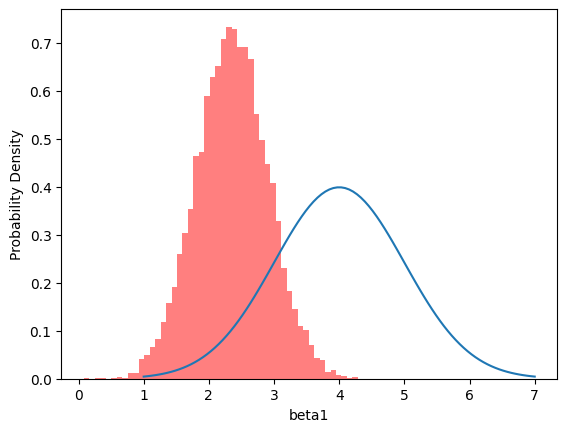

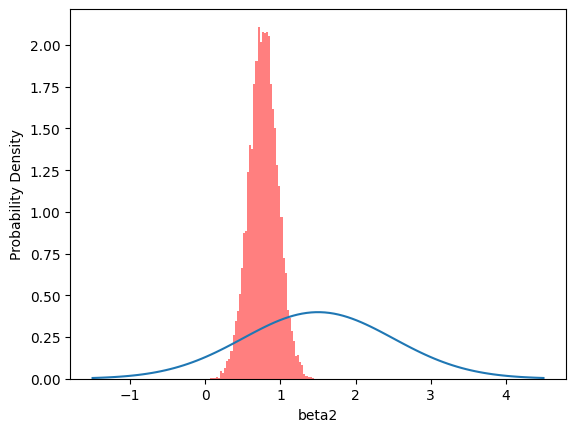

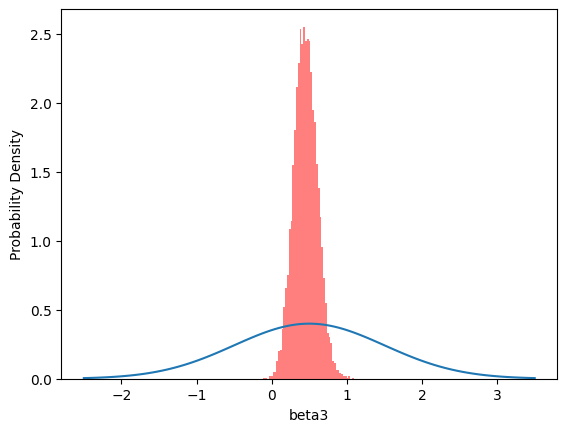

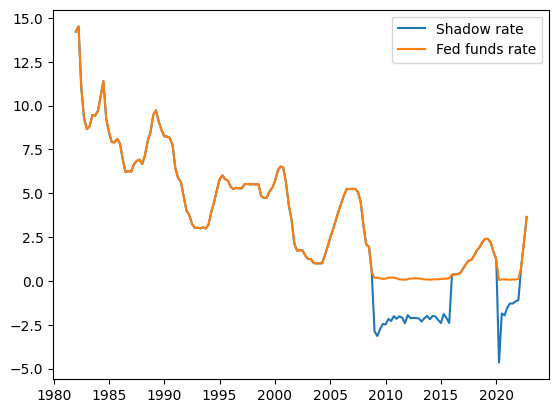

In [2]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import csv
from progressbar import progressbar

# Tobit censored linear regression
def tobit(y, x, n, beta0, B0, alpha0, delta0, c):
    # Initialization
    ind = np.where(y < c)[0]
    sample = {'beta': np.zeros((n, len(beta0))), 'sig2': np.zeros((n, 1)), 'z': np.zeros((n, len(ind)))}
    sample['beta'][0, :] = beta0
    sample['sig2'][0] = (delta0 / 2) / (alpha0 / 2 - 1)
    sample['z'][0, :] = c - 0.1
    alpha1 = alpha0 + len(y)
    
    # Sampling
    for i in progressbar(range(1, n)):
        y[ind] = sample['z'][i - 1, :].reshape(-1, 1)
        B1 = np.linalg.inv(x.T @ x / sample['sig2'][i - 1] + np.linalg.inv(B0))
        beta1 = B1 @ (x.T @ y / sample['sig2'][i - 1] + np.linalg.inv(B0) @ beta0.reshape(-1,1))
        sample['beta'][i, :] = stats.multivariate_normal.rvs(size=1, mean=beta1.ravel(), cov=B1)
        
        m = x @ sample['beta'][i, :].reshape(-1, 1)
        delta1 = delta0 + (y - m).T @ (y - m)
        sample['sig2'][i] = stats.invgamma.rvs(alpha1 / 2, size=1, scale=delta1 / 2)

        for j in range(len(ind)):
            b = (c - m[ind[j]]) / np.sqrt(sample['sig2'][i])
            sample['z'][i, j] = stats.truncnorm.rvs(-1e3, b, loc=m[ind[j]], scale=np.sqrt(sample['sig2'][i]), size=1)
        
    return sample

# Import Taylor rule data
with open("taylor.csv", "r") as file:
    reader = csv.reader(file)
    header = next(reader)
    data = [row for row in reader]

data = np.array(data, dtype=float)
begin = 110
end = 274
date = data[begin:end, header.index('Date')]
y = data[begin:end, header.index('R')].reshape(-1, 1)
x = np.zeros((len(y), 3))
x[:, 0] = 1
x[:, 1] = data[begin:end, header.index('P')]
x[:, 2] = data[begin:end, header.index('Y')]

# Prior and posterior
beta0 = np.array([4, 1.5, 0.5])
B0 = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
alpha0 = 5
delta0 = 5
c = 0.25
sample = tobit(y.copy(), x, 11000, beta0, B0, alpha0, delta0, c)
sample['beta'] = sample['beta'][1000:11000, :]
sample['sig2'] = sample['sig2'][1000:11000]
sample['z'] = sample['z'][1000:11000, :]

# Plot
beta1 = np.linspace(1, 7, 100)
plt.plot(beta1, stats.norm.pdf(beta1, loc=4, scale=1))
plt.hist(sample['beta'][:, 0], bins=50, density=True, color="red", alpha=0.5)
plt.xlabel("beta1")
plt.ylabel("Probability Density")
plt.show()
beta2 = np.linspace(-1.5, 4.5, 100)
plt.plot(beta2, stats.norm.pdf(beta2, loc=1.5, scale=1))
plt.hist(sample['beta'][:, 1], bins=50, density=True, color="red", alpha=0.5)
plt.xlabel("beta2")
plt.ylabel("Probability Density")
plt.show()
beta3 = np.linspace(-2.5, 3.5, 100)
plt.plot(beta3, stats.norm.pdf(beta3, loc=0.5, scale=1))
plt.hist(sample['beta'][:, 2], bins=50, density=True, color="red", alpha=0.5)
plt.xlabel("beta3")
plt.ylabel("Probability Density")
plt.show()
ind = np.where(y < c)[0]
yz = y.copy()
yz[ind] = np.mean(sample['z'], axis=0).reshape(-1, 1)
plt.plot(date, yz, label='Shadow rate')
plt.plot(date, y, label='Fed funds rate')
plt.legend()
plt.show()